In [1]:
# Input info
# se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/clones/"
# N_DONORS = 2
# condition = "inputOnly" # noInput

#config
input_cond = "Input"
clone_col = "name"
atac_col = "cluster_labels"

# params
min_clone_size = 10
p_thresh = 0.1 

n_cpus = 12

n_shuffle=1000
#conds_sep = False


se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/se_cells_meta_labels.tsv"  
outdir = "/data/Mito_Trace/output/pipeline/v03/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_3" 
N_DONORS = 4 
condition = "inputOnly"



In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)
    
if not exists(sep_dir):
    os.mkdir(sep_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

## Load cells_meta

In [5]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Control_AAACGAAAGAGGTCCA-1,Control,1357,1357,16929,2587,58,70,674,9629,3911,...,3,2025,1719,AAACGAAAGAGGTCCA-1_Control,Control_AAACGAAAGAGGTCCA-1,0,1,Control,1_0,Eosinophil
Control_AAACGAAAGCGATACG-1,Control,3505,3505,45359,10546,184,184,2302,22247,9896,...,0,5299,3845,AAACGAAAGCGATACG-1_Control,Control_AAACGAAAGCGATACG-1,3,3,Control,3_3,macrophages
Control_AAACGAAAGTCGTGAG-1,Control,994,994,10177,2450,48,60,657,2135,4827,...,5,2066,1694,AAACGAAAGTCGTGAG-1_Control,Control_AAACGAAAGTCGTGAG-1,21,2,Control,2_21,Erythroid
Control_AAACGAACAATAGTGA-1,Control,2687,2687,22452,4364,100,83,897,9233,7775,...,0,3746,2775,AAACGAACAATAGTGA-1_Control,Control_AAACGAACAATAGTGA-1,31,1,Control,1_31,macrophages
Control_AAACGAACACAATAAG-1,Control,1184,1184,11763,2003,43,57,680,5547,3433,...,5,1866,1641,AAACGAACACAATAAG-1_Control,Control_AAACGAACACAATAAG-1,31,2,Control,2_31,Erythroid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flt3l_TTTGTGTTCCTTTGCG-1,Flt3l,2737,2737,25608,4593,78,159,1486,11639,7653,...,4,4322,3369,TTTGTGTTCCTTTGCG-1_Flt3l,Flt3l_TTTGTGTTCCTTTGCG-1,14,3,Flt3l,3_14,neutrophil
Flt3l_TTTGTGTTCGAGTTAC-1,Flt3l,2680,2680,17658,2695,42,85,1186,5949,7701,...,4,4305,3338,TTTGTGTTCGAGTTAC-1_Flt3l,Flt3l_TTTGTGTTCGAGTTAC-1,52,2,Flt3l,2_52,neutrophil
Flt3l_TTTGTGTTCGTGGTAT-1,Flt3l,1510,1510,9188,1165,33,42,620,3337,3991,...,4,2336,2023,TTTGTGTTCGTGGTAT-1_Flt3l,Flt3l_TTTGTGTTCGTGGTAT-1,13,3,Flt3l,3_13,neutrophil
Flt3l_TTTGTGTTCGTTACAG-1,Flt3l,4063,4063,35699,6656,184,194,1921,15800,10944,...,1,5881,4209,TTTGTGTTCGTTACAG-1_Flt3l,Flt3l_TTTGTGTTCGTTACAG-1,17,1,Flt3l,1_17,neutrophil


## Map the new group to cells_meta

## Filter for condition

In [6]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
#sns.countplot(data=cells_meta,x=clone_col)
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels


## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

In [7]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)

#     print("plotting counts")
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
#     curr_groups = curr_groups.drop("log2_count", axis=1)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)

    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     g.fig.suptitle(f"Hypergeometric distribution p-values - non-significant values (p={p_thresh}) are zeroes")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=n_cpus)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    


## B) Run using all donors as background

Running hypergeo and saving sig results
plotting counts


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


ValueError: The number of observations cannot be determined on an empty distance matrix.

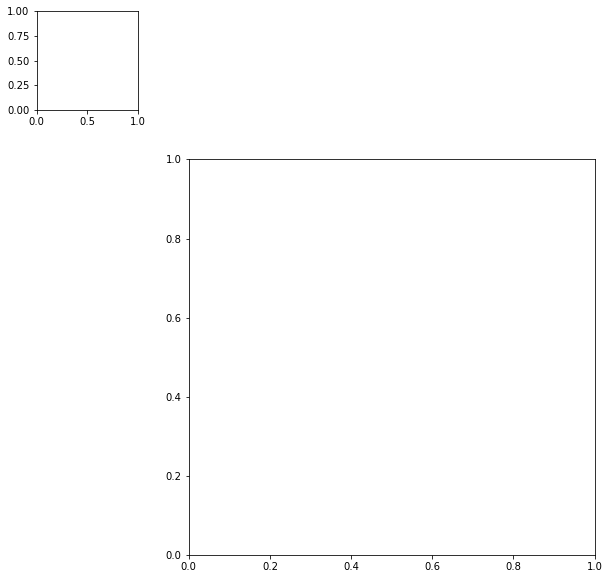

In [8]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# # plot just the counts
# print("plotting counts")
# groups["log2_count"] = np.log2(groups["count"]+1)
# g = sns.clustermap(groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# plt.gca().set_title("log2 ncells")
# plt.savefig(join(all_dir, "ncells.png"))


# print("Running hypergeo and saving sig results")
# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)
# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_padjusted_sigOnly.csv"))
    
# if output_df.shape[0] == 0:   
#     g = sns.heatmap(-np.log10(bh_enrichment_df.fillna(1)))
#     g.fig.suptitle("No groups were significant")
# else:
#     g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                    row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_padjusted_sigOnly.png"))

# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                       all_dir=sim_all_dir)

In [ ]:
out_df

In [ ]:
# results_df

# ## Plot shuffle p-value heatmap for each method 

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# ## Same but log10

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     min_m = min(val.loc[val["value"] != 0 , "value"])
#     val.loc[val["value"] == 0 ,"value"] = min_m
    
#     g = sns.clustermap(-np.log10(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1)))
#     plt.suptitle(ind)
#     g.ax_cbar.set(title=f"-log10 p-val;cutoff is {-np.log10(p_thresh)}")
#     # g.ax_cbar.set(title="-log10 p-value")

    
    

# ## Save significant results_df

# out_df = results_df.rename({"value":"p_value shuffle", "index":"clone", "variable":"lineage"}, axis=1)
# out_df = out_df[out_df["p_value shuffle"]<p_thresh]

# init_p_df = init_bh_enrichment.reset_index().melt(id_vars=["index"]).rename({"variable":"lineage", "index":"clone",
#                                                                           "value": "BH_p_adj"},axis=1).set_index(["clone", "lineage"])
# init_p_df
# #pd.merge(init_p_df, out_df, on=["clone", "lineage"], how="inner" )

# out_df["BH_p_adj"] = out_df.apply(lambda x:init_p_df.loc[(x["clone"],x["lineage"]), "BH_p_adj"], axis=1)
# out_df

# out_df.sort_values(["method", "p_value shuffle", "BH_p_adj"])

# out_df[out_df["BH_p_adj"] != 1]